# HMI SPINN

In [1]:
from setproctitle import setproctitle

setproctitle("HMI SPINN")

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [3]:
from zpinn.pinn_nf2_cleanup import create_coordinates
from zpinn.spinn_cleanup_new import SPINN3d, generate_train_data, apply_model_spinn, update_model

In [4]:
import jax 
import jax.numpy as jnp
import optax
import numpy as np 
import matplotlib.pyplot as plt
import time 
import pickle
from tqdm import trange

In [5]:
path = 'NOAA11429_20120307_110000'

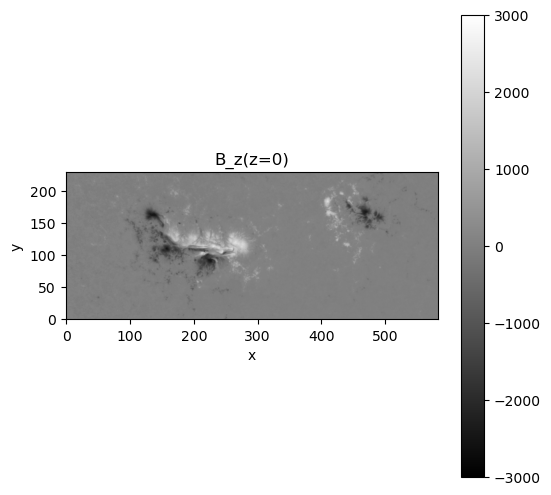

In [6]:
input_path = f'01_input/{path}/'
bottom_npy_path = os.path.join(input_path, 'b_bottom.npy')

with open(bottom_npy_path, 'rb') as f:
        b_bottom = np.load(f)

plt.close()
fig, ax = plt.subplots(figsize=(6,6))
CS = plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower', cmap='gray', vmin=-3000, vmax=3000)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("B_z(z=0)")
fig.colorbar(CS)
plt.show()

In [7]:
output_path = f'02_output/{path}/SPINN'

Nx, Ny, _ = b_bottom.shape
Nz = 160

spatial_norm = 160
b_norm = 2500

In [8]:
boundary_path = os.path.join(output_path, 'boundary')
os.makedirs(boundary_path, exist_ok=True)
boundary_npy_path = os.path.join(boundary_path, 'boundary_data.pickle')

In [9]:
epochs = 10000
log_iter = 1000

features = 256
n_layers = 8 
feat_sizes = tuple([features for _ in range(n_layers)]) 
r = 128 
out_dim = 3 

lr = 5e-4

In [ ]:
from zpinn.create_pot import get_potential_boundary

In [ ]:
coords, fields = get_potential_boundary(b_bottom[:, :, 2], Nz)

bp_top = fields[0]
bp_lateral_3 = fields[1]
bp_lateral_4 = fields[2]
bp_lateral_1 = fields[3]
bp_lateral_2 = fields[4]

b_bottom_norm = b_bottom / b_norm
bp_top_norm = bp_top / b_norm
bp_lateral_1_norm = bp_lateral_1 / b_norm
bp_lateral_2_norm = bp_lateral_2 / b_norm
bp_lateral_3_norm = bp_lateral_3 / b_norm 
bp_lateral_4_norm = bp_lateral_4 / b_norm

boundary_data = (b_bottom_norm, bp_top_norm, bp_lateral_1_norm, bp_lateral_2_norm, bp_lateral_3_norm, bp_lateral_4_norm)

with open(boundary_npy_path, "wb") as f:
    pickle.dump(boundary_data, f)

Potential Field: 100%|██████████| 578/578 [00:45<00:00, 12.74it/s]


In [14]:
with open(boundary_npy_path, 'rb') as f:
        boundary_data = pickle.load(f)

In [15]:
seed = 111
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key, 2)

In [16]:
model = SPINN3d(feat_sizes, r, out_dim, pos_enc=0, mlp='modified_mlp')
params = model.init(
            subkey,
            jnp.ones((Nx, 1)),
            jnp.ones((Ny, 1)),
            jnp.ones((Nz, 1))
        )
apply_fn = jax.jit(model.apply)
optim = optax.adam(learning_rate=lr)
state = optim.init(params)

In [17]:
key, subkey = jax.random.split(key, 2)
# train_data = generate_train_data(subkey, Nx, Ny, Nz) #normal
train_data = generate_train_data(subkey, Nx, Ny, Nz, nc=128)
train_boundary_data = [train_data, boundary_data]

In [18]:
losses = []

In [19]:
loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
losses.append(loss.item())
params, state = update_model(optim, gradient, params, state)

In [20]:
params_path = os.path.join(output_path, "params_0.pickle")
with open(params_path, "wb") as f:
    pickle.dump(params, f)

In [21]:
start = time.time()
for e in trange(1, epochs + 1):
    
    # if e % 300 == 0:
    #     # sample new input data
    #     key, subkey = jax.random.split(key, 2)
    #     generate_train_data(subkey, Nx, Ny, Nz, nc=160)

    loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
    losses.append(loss.item())
    params, state = update_model(optim, gradient, params, state)
    
    if e % log_iter == 0:
        print(f'Epoch: {e}/{epochs} --> total loss: {loss:.8f}')
        params_path = os.path.join(output_path, f"params_{e}.pickle")
        with open(params_path, "wb") as f:
            pickle.dump(params, f)

np.save(os.path.join(output_path, 'losses.npy'), losses)
runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(epochs-1)*1000):.2f}ms/iter.)')

 10%|█         | 1007/10000 [00:28<04:14, 35.38it/s]

Epoch: 1000/10000 --> total loss: 0.01334235


 20%|██        | 2005/10000 [00:57<03:58, 33.57it/s]

Epoch: 2000/10000 --> total loss: 0.00986574


 30%|███       | 3005/10000 [01:24<03:26, 33.90it/s]

Epoch: 3000/10000 --> total loss: 0.00846437


 40%|████      | 4004/10000 [01:52<02:44, 36.41it/s]

Epoch: 4000/10000 --> total loss: 0.00789398


 50%|█████     | 5005/10000 [02:20<02:07, 39.07it/s]

Epoch: 5000/10000 --> total loss: 0.00640716


 60%|██████    | 6004/10000 [02:45<01:53, 35.26it/s]

Epoch: 6000/10000 --> total loss: 0.00601889


 70%|███████   | 7003/10000 [03:13<01:28, 33.87it/s]

Epoch: 7000/10000 --> total loss: 0.00599003


 80%|████████  | 8005/10000 [03:41<00:52, 38.15it/s]

Epoch: 8000/10000 --> total loss: 0.00552010


 90%|█████████ | 9005/10000 [04:08<00:27, 36.02it/s]

Epoch: 9000/10000 --> total loss: 0.01129593


100%|██████████| 10000/10000 [04:35<00:00, 36.26it/s]

Epoch: 10000/10000 --> total loss: 0.00508807
Runtime --> total: 275.77sec (27.58ms/iter.)


In [22]:
with open(os.path.join(output_path, 'losses.npy'), "rb") as f:
    losses = np.load(f)

Text(0, 0.5, 'Loss')

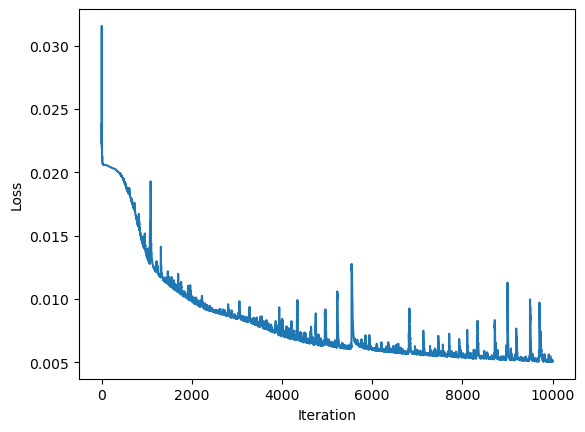

In [23]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [18]:
# normal
start = time.time()
for e in trange(1, epochs + 1):
    
    # if e % 300 == 0:
    #     # sample new input data
    #     key, subkey = jax.random.split(key, 2)
    #     generate_train_data(subkey, Nx, Ny, Nz, nc=160)

    loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
    losses.append(loss.item())
    params, state = update_model(optim, gradient, params, state)
    
    if e % log_iter == 0:
        print(f'Epoch: {e}/{epochs} --> total loss: {loss:.8f}')
        params_path = os.path.join(output_path, f"params_{e}.pickle")
        with open(params_path, "wb") as f:
            pickle.dump(params, f)

np.save(os.path.join(output_path, 'losses.npy'), losses)
runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(epochs-1)*1000):.2f}ms/iter.)')

 10%|█         | 1002/10000 [01:07<10:23, 14.43it/s]

Epoch: 1000/10000 --> total loss: 0.01368835


 20%|██        | 2002/10000 [02:15<09:01, 14.77it/s]

Epoch: 2000/10000 --> total loss: 0.00990028


 30%|███       | 3002/10000 [03:22<07:51, 14.83it/s]

Epoch: 3000/10000 --> total loss: 0.00869638


 40%|████      | 4002/10000 [04:29<06:51, 14.58it/s]

Epoch: 4000/10000 --> total loss: 0.00713707


 50%|█████     | 5002/10000 [05:36<05:51, 14.21it/s]

Epoch: 5000/10000 --> total loss: 0.00640674


 60%|██████    | 6002/10000 [06:44<04:28, 14.88it/s]

Epoch: 6000/10000 --> total loss: 0.00593525


 70%|███████   | 7002/10000 [07:51<03:37, 13.80it/s]

Epoch: 7000/10000 --> total loss: 0.00567142


 80%|████████  | 8002/10000 [08:58<02:15, 14.78it/s]

Epoch: 8000/10000 --> total loss: 0.00543500


 90%|█████████ | 9002/10000 [10:05<01:11, 14.02it/s]

Epoch: 9000/10000 --> total loss: 0.00533224


100%|██████████| 10000/10000 [11:13<00:00, 14.85it/s]

Epoch: 10000/10000 --> total loss: 0.00521687
Runtime --> total: 673.45sec (67.35ms/iter.)


In [19]:
with open(os.path.join(output_path, 'losses.npy'), "rb") as f:
    losses = np.load(f)

Text(0, 0.5, 'Loss')

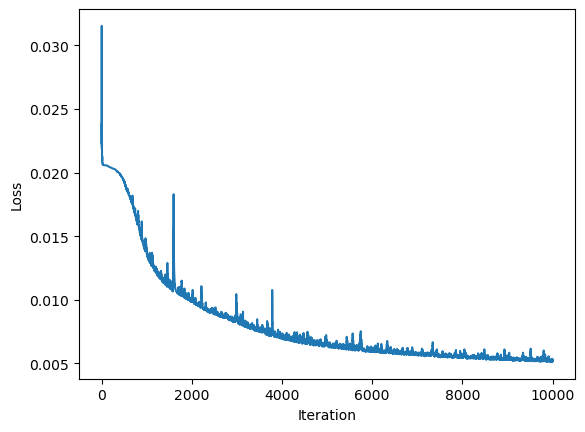

In [20]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [24]:
import pyvista as pv
from zpinn.spinn_cleanup import load_spinn_mag

In [25]:
eval_path = f'03_eval/{path}/SPINN'
os.makedirs(eval_path, exist_ok=True)

In [26]:
def ctr_mesh(vtk_path, param_path, Nx, Ny, Nz, b_norm):
    
    B = load_spinn_mag(param_path, Nx, Ny, Nz, b_norm)

    Bx = B[..., 0]
    By = B[..., 1]
    Bz = B[..., 2]

    co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
    co_coords = create_coordinates(co_bounds).reshape(-1, 3)
    co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
    x = co_coord[..., 0]
    y = co_coord[..., 1]
    z = co_coord[..., 2]
    mesh = pv.StructuredGrid(x, y, z)
    vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
    mesh['B'] = vectors
    mesh.active_vectors_name = 'B'
    magnitude = np.linalg.norm(vectors, axis=-1)
    mesh['mag'] = magnitude
    mesh.active_scalars_name = 'mag'
    mesh.save(vtk_path)

In [27]:
iterations = np.arange(0, epochs+1, log_iter)

for epo in iterations:
    param_path = os.path.join(output_path, f"params_{epo}.pickle")
    vtk_paths = os.path.join(eval_path, f'B_spinn_{epo}.vtk')
    ctr_mesh(vtk_paths, param_path, Nx, Ny, Nz, b_norm)
    print(epo)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
